# Апробация моделей частотных сканов на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## 0. Импорт модулей

In [2]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from pydlts.fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from pydlts.fsplots import plot_experimental_points
from pydlts.fsplots import plot_spectr
from pydlts.fsplots import plot_model
from pydlts.fsplots import plot_loss_path
from pydlts.fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [3]:
DATASETS_PATH = '../datasets/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [4]:
file_names = listdir(DATASETS_PATH)

### 1.1. Выберем данные полученные при $U_1 = -4$ В и $U_R = -5$ В
Данному критерию соответствуют 3 частотных скана

In [5]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASETS_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [6]:
len(data_frames)

3

Отсортируем частотные сканы по температуре в начале сканирования

In [7]:
key_func = lambda x: x[1].temperature_k.iloc[0]
data_frames.sort(key=key_func)

for i, item in enumerate(data_frames):
    print(f'{i}.', item[0])

0. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv
1. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv
2. 1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = -10^\circ C$

In [8]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [9]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +10^\circ C$

In [10]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [11]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +30^\circ C$

In [12]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 34 точки. Данные не содержат пропусков.

In [13]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv.csv
### 2.1. Подготовка экспериментальных данных

Чтение данных

In [14]:
print(data_frames[0][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


In [15]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    df = dataset.sample(frac=1, random_state=42)
    
    X_train = np.log10(df.frequency_hz.to_numpy())
    y_train = df.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train

In [16]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

Выведем тренировачный набор данных

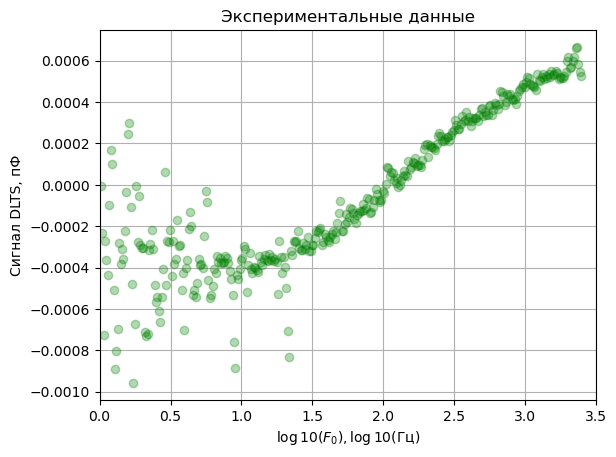

In [17]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$
Идентификация модели:

In [18]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-3.0, 0.0002]])

2022-10-09 16:25:48.724920: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:25:48.724940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 16:25:48.724945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 16:25:48.725063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 16:25:48.725075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 16:25:48.725078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 16:25:48.725454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [19]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl']

Вывод табличных результатов идентификации

In [20]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_1.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
236,0.000537,0.00001,True,0.05,8.443109e-08,1,1000,0.806325,0.00001,-3.541570,False
237,0.000537,0.00001,True,0.05,8.443021e-08,1,1000,0.805889,0.00001,-3.541870,False
238,0.000537,0.00001,True,0.05,8.442934e-08,1,1000,0.805455,0.00001,-3.542169,False
239,0.000537,0.00001,True,0.05,8.442848e-08,1,1000,0.805021,0.00001,-3.542466,False
240,0.000538,0.00001,True,0.05,8.442764e-08,1,1000,0.804588,0.00001,-3.542761,False
241,0.000538,0.00001,True,0.05,8.442681e-08,1,1000,0.804156,0.00001,-3.543055,False
242,0.000538,0.00001,True,0.05,8.442599e-08,1,1000,0.803724,0.00001,-3.543347,False
243,0.000538,0.00001,True,0.05,8.442518e-08,1,1000,0.803294,0.00001,-3.543637,False
244,0.000538,0.00001,True,0.05,8.442438e-08,1,1000,0.802864,0.00001,-3.543926,False
245,0.000538,0.00001,True,0.05,8.442360e-08,1,1000,0.802435,0.00001,-3.544214,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

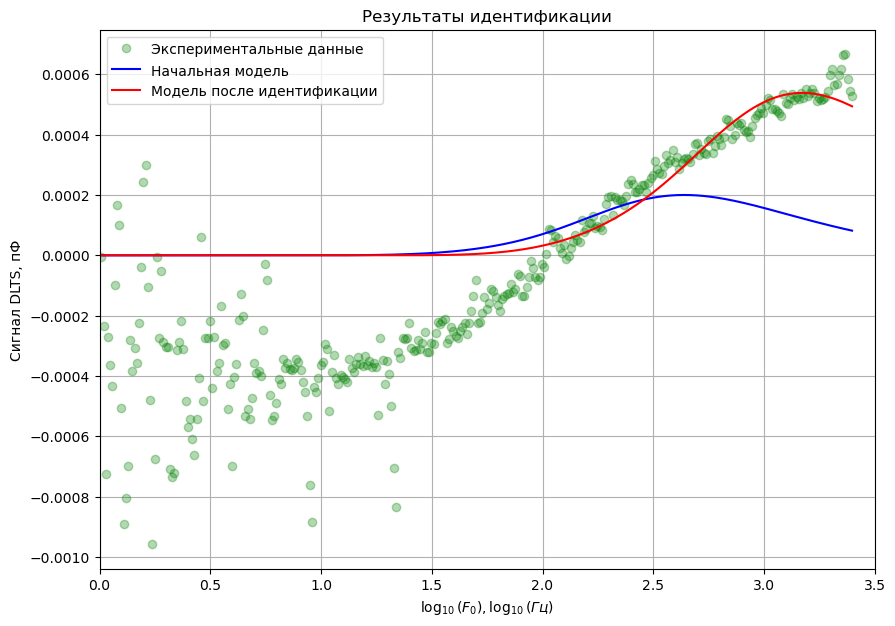

In [21]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

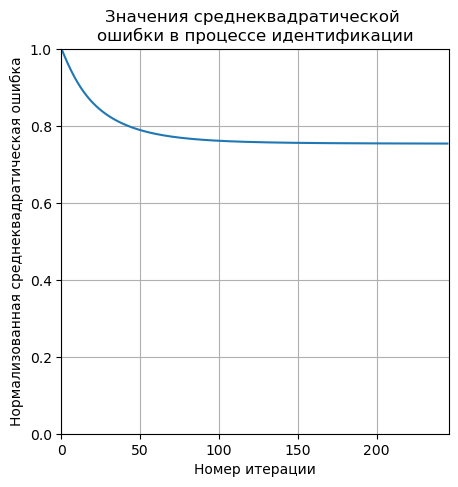

In [22]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_1.pdf',
            bbox_inches='tight')
plt.show()

График выходит на "плато", что свидетельствует о том, что решение сошлось, однако довольно высокое значение среднеквадратической ошибки может указывать на то, что алгоритм нашёл локальный минимум функции потерь. О последнем также свидетельсвует предыдущий график (графика с экспериментальными данными и данными полученными на идентифицированной модели).

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

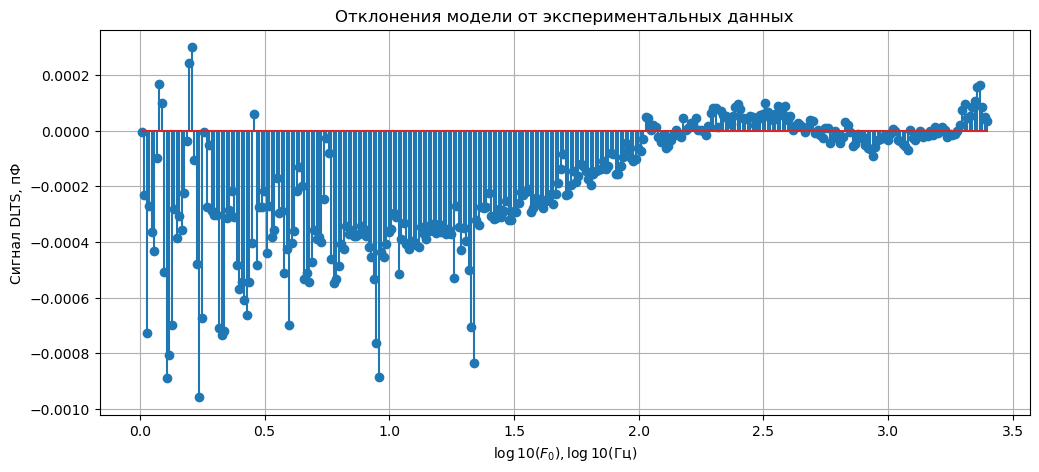

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_1.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

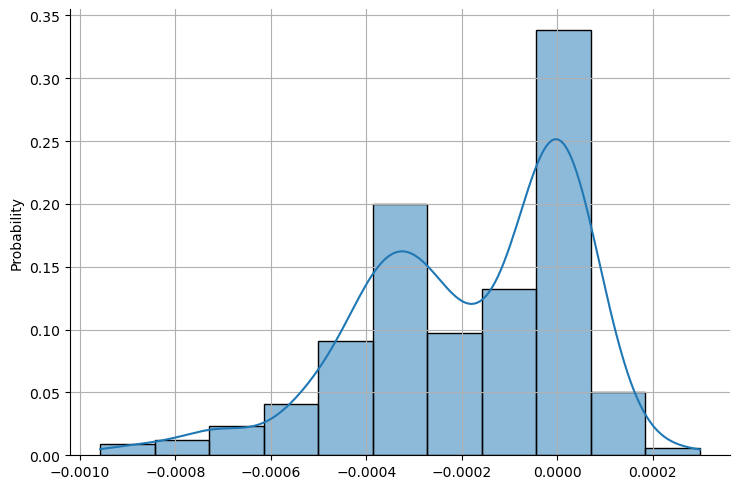

In [24]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_1.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [25]:
def display_scores(scores):
    print('Scores - корни из среднеквадратических ошибок')
    scores = np.sqrt(-scores)
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [26]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-3.0, 0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 16:26:22.025823: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:26:22.025848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 16:26:22.025852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 16:26:22.025954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 16:26:22.025966: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 16:26:22.025970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 16:26:22.026073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00032577 0.00028899 0.00029729 0.00025019 0.00028567]
Mean: 0.0002895813399013814
Standard deviation: 2.4235807663706078e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [27]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00029055738927178423

Выведем на экран полученный спектр

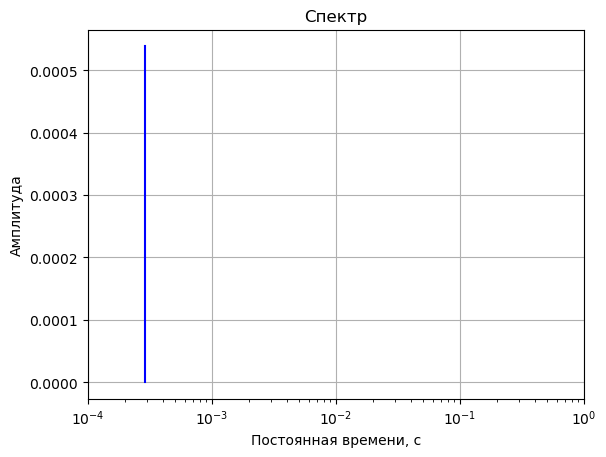

In [28]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_1.pdf',
            bbox_inches='tight')
plt.show()

Попробуем идентифицировать модель задав другую начальную точку для идентификации.

Идентификация модели с начальной точкой близкой к отрицательному пику

In [29]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-1.5, -0.0002]])

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраим модель

In [30]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl']

Вывод табличных результатов идентификации

In [31]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_2.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
163,-0.000475,0.00001,True,0.05,8.183327e-08,1,1000,1.032274,0.00001,-1.038129,False
164,-0.000475,0.00001,True,0.05,8.183226e-08,1,1000,1.032759,0.00001,-1.038218,False
165,-0.000475,0.00001,True,0.05,8.183129e-08,1,1000,1.033239,0.00001,-1.038306,False
166,-0.000475,0.00001,True,0.05,8.183034e-08,1,1000,1.033712,0.00001,-1.038393,False
167,-0.000476,0.00001,True,0.05,8.182943e-08,1,1000,1.034179,0.00001,-1.038479,False
168,-0.000476,0.00001,True,0.05,8.182854e-08,1,1000,1.034640,0.00001,-1.038563,False
169,-0.000476,0.00001,True,0.05,8.182768e-08,1,1000,1.035095,0.00001,-1.038647,False
170,-0.000476,0.00001,True,0.05,8.182684e-08,1,1000,1.035544,0.00001,-1.038730,False
171,-0.000476,0.00001,True,0.05,8.182604e-08,1,1000,1.035988,0.00001,-1.038812,False
172,-0.000476,0.00001,True,0.05,8.182525e-08,1,1000,1.036426,0.00001,-1.038892,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

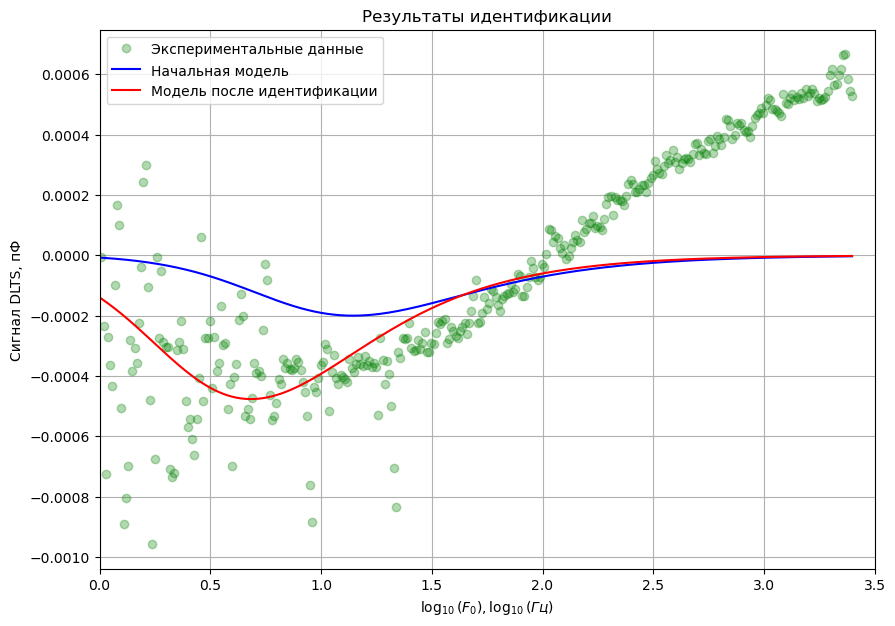

In [32]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

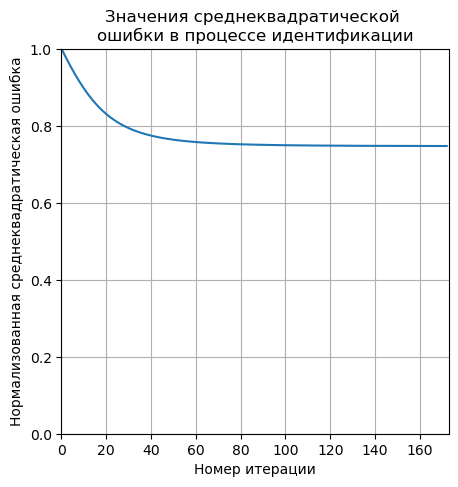

In [33]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_2.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

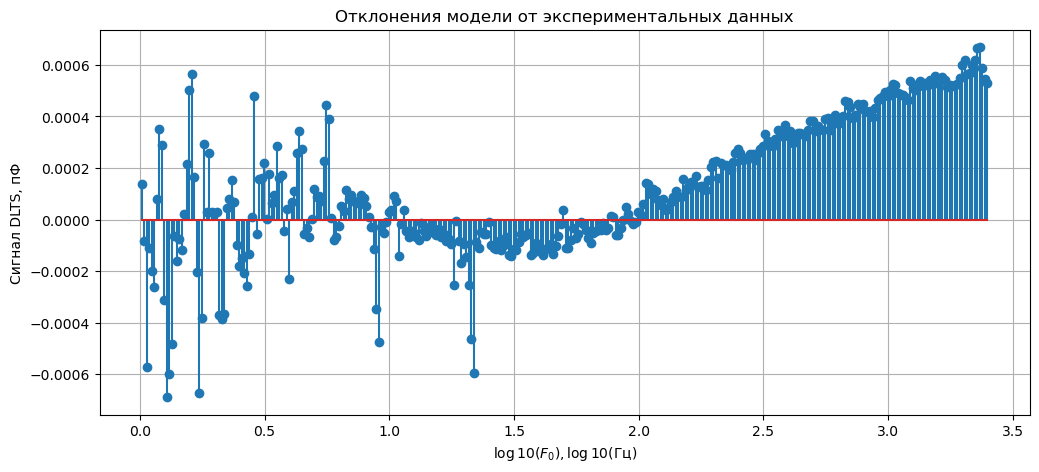

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_2.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

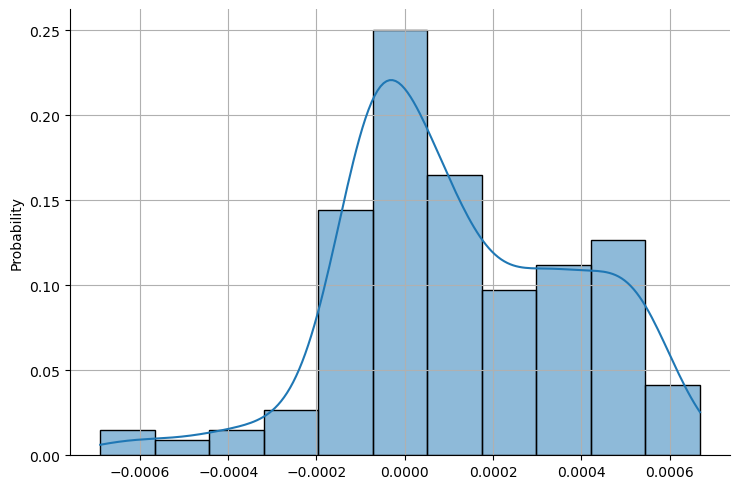

In [35]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_2.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [36]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-1.5, -0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 16:27:21.577692: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:27:21.577716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 16:27:21.577720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 16:27:21.577831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 16:27:21.577845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 16:27:21.577849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 16:27:21.577945: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:27:21.577956: I tenso

Scores - корни из среднеквадратических ошибок
Scores: [0.00032654 0.0002868  0.00024652 0.00031121 0.00026487]
Mean: 0.0002871881997596424
Standard deviation: 2.9249683808086568e-05


Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [37]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0002860511340652706

Выведем на экран полученный спектр

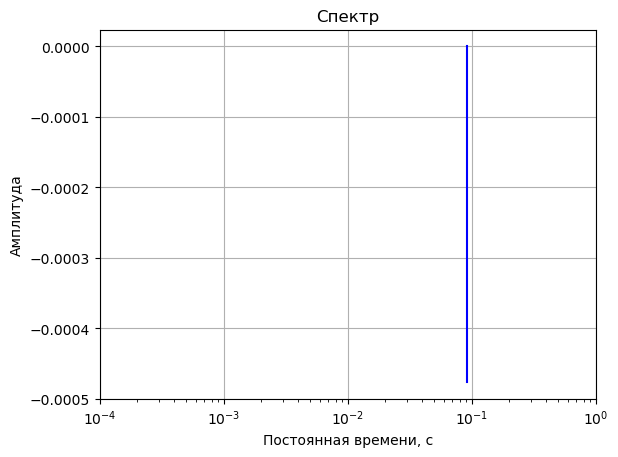

In [38]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_2.pdf',
            bbox_inches='tight')
plt.show()

### 2.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [39]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [40]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [41]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
238,0.000534,0.00001,False,0.05,8.472423e-08,1,1000,1.0,0.00001,-3.484091,False
239,0.000534,0.00001,False,0.05,8.472324e-08,1,1000,1.0,0.00001,-3.484265,False
240,0.000534,0.00001,False,0.05,8.472228e-08,1,1000,1.0,0.00001,-3.484437,False
241,0.000534,0.00001,False,0.05,8.472135e-08,1,1000,1.0,0.00001,-3.484606,False
242,0.000535,0.00001,False,0.05,8.472044e-08,1,1000,1.0,0.00001,-3.484773,False
243,0.000535,0.00001,False,0.05,8.471956e-08,1,1000,1.0,0.00001,-3.484937,False
244,0.000535,0.00001,False,0.05,8.471871e-08,1,1000,1.0,0.00001,-3.485099,False
245,0.000535,0.00001,False,0.05,8.471788e-08,1,1000,1.0,0.00001,-3.485259,False
246,0.000535,0.00001,False,0.05,8.471708e-08,1,1000,1.0,0.00001,-3.485417,False
247,0.000536,0.00001,False,0.05,8.471630e-08,1,1000,1.0,0.00001,-3.485573,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

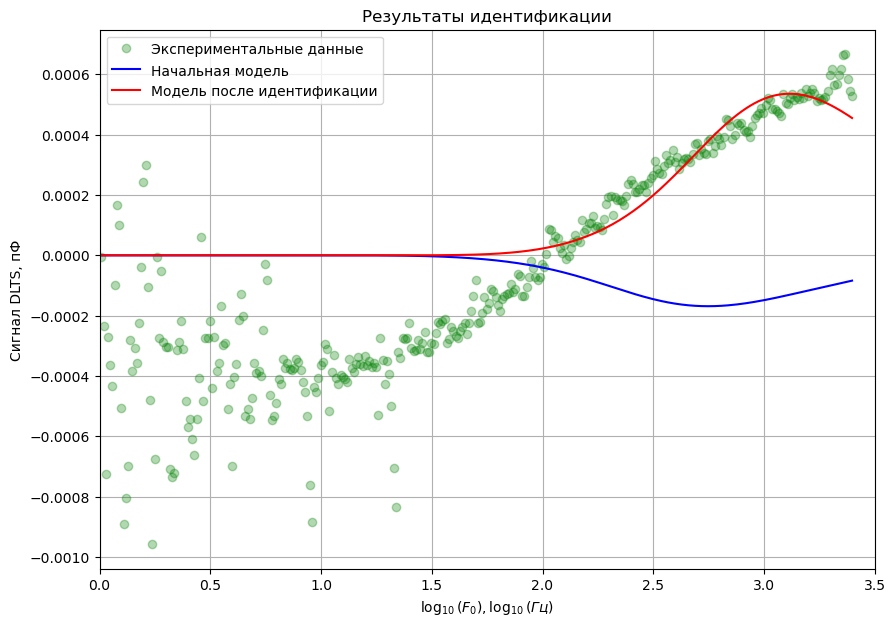

In [42]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

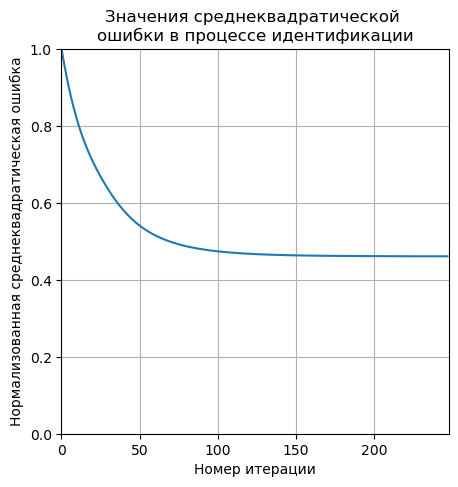

In [43]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

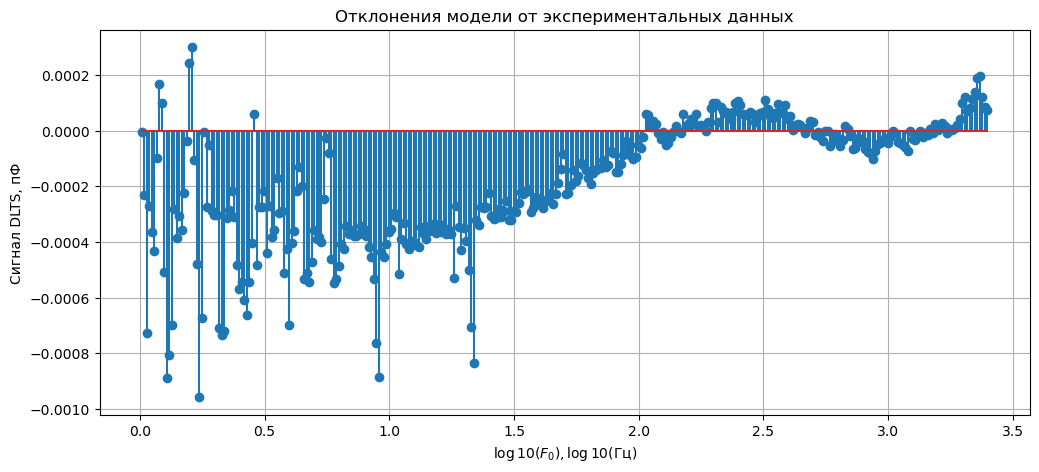

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

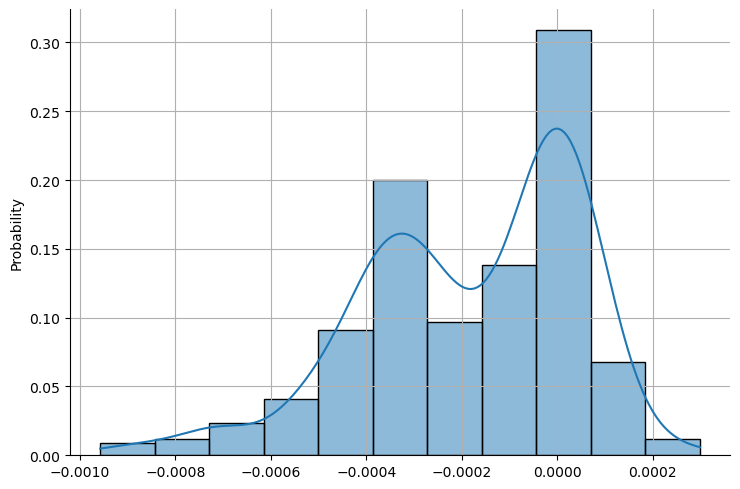

In [45]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [46]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 16:28:19.346674: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:28:19.346698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 16:28:19.346702: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 16:28:19.346805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 16:28:19.346818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 16:28:19.346822: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 16:28:19.346931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00032653 0.00028701 0.00024665 0.00025089 0.00028616]
Mean: 0.00027944477768821743
Standard deviation: 2.901809773331523e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [47]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0002910606388772877

Выведем на экран полученный спектр

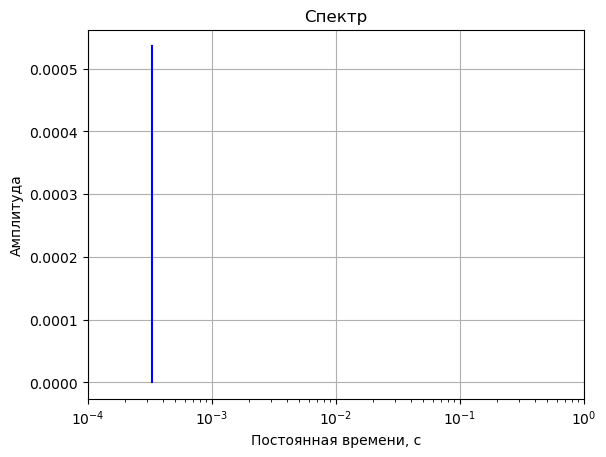

In [48]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [49]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [50]:
param_grid = {'n_exps': [5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [51]:
grid_search.fit(X_train, y_train)

2022-10-09 16:28:52.320929: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 16:28:52.320965: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 16:28:52.320972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 16:28:52.321171: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 16:28:52.321198: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 16:28:52.321205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 16:28:52.321417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [52]:
grid_search.best_params_

{'n_exps': 8}

Сохраним объект GridSearchCV

In [53]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.0001372743174091173 {'n_exps': 5}
0.00013612778974254864 {'n_exps': 6}
0.00013466157776390755 {'n_exps': 7}
0.00013452959745829008 {'n_exps': 8}
0.00013534280388320896 {'n_exps': 9}
0.0001349257330937831 {'n_exps': 10}


Сохраним лучшую модель

In [55]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [56]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,filling_pulse,learning_rate,...,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,verbose
990,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000388,0.000140,0.000212,0.00001,0.05,...,0.00001,-3.879640,-2.562028,-2.787586,-1.847020,-1.764778,-0.808424,-2.870846,-3.639617,False
991,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000388,0.000140,0.000212,0.00001,0.05,...,0.00001,-3.879681,-2.561990,-2.787642,-1.846596,-1.764315,-0.808176,-2.871005,-3.639558,False
992,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000388,0.000140,0.000212,0.00001,0.05,...,0.00001,-3.879723,-2.561952,-2.787698,-1.846172,-1.763852,-0.807929,-2.871164,-3.639500,False
993,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000388,0.000140,0.000212,0.00001,0.05,...,0.00001,-3.879765,-2.561915,-2.787753,-1.845749,-1.763391,-0.807682,-2.871323,-3.639441,False
994,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000388,0.000140,0.000213,0.00001,0.05,...,0.00001,-3.879807,-2.561877,-2.787810,-1.845327,-1.762931,-0.807435,-2.871483,-3.639382,False
995,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000387,0.000140,0.000213,0.00001,0.05,...,0.00001,-3.879849,-2.561840,-2.787866,-1.844905,-1.762472,-0.807188,-2.871642,-3.639323,False
996,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000387,0.000140,0.000213,0.00001,0.05,...,0.00001,-3.879891,-2.561802,-2.787922,-1.844484,-1.762014,-0.806942,-2.871802,-3.639264,False
997,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000387,0.000140,0.000213,0.00001,0.05,...,0.00001,-3.879934,-2.561765,-2.787979,-1.844064,-1.761556,-0.806696,-2.871961,-3.639205,False
998,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000387,0.000139,0.000213,0.00001,0.05,...,0.00001,-3.879977,-2.561728,-2.788036,-1.843644,-1.761100,-0.806451,-2.872121,-3.639146,False
999,0.000301,0.000022,0.000102,-0.000113,-0.000135,-0.000387,0.000139,0.000213,0.00001,0.05,...,0.00001,-3.880020,-2.561691,-2.788093,-1.843225,-1.760645,-0.806205,-2.872280,-3.639086,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

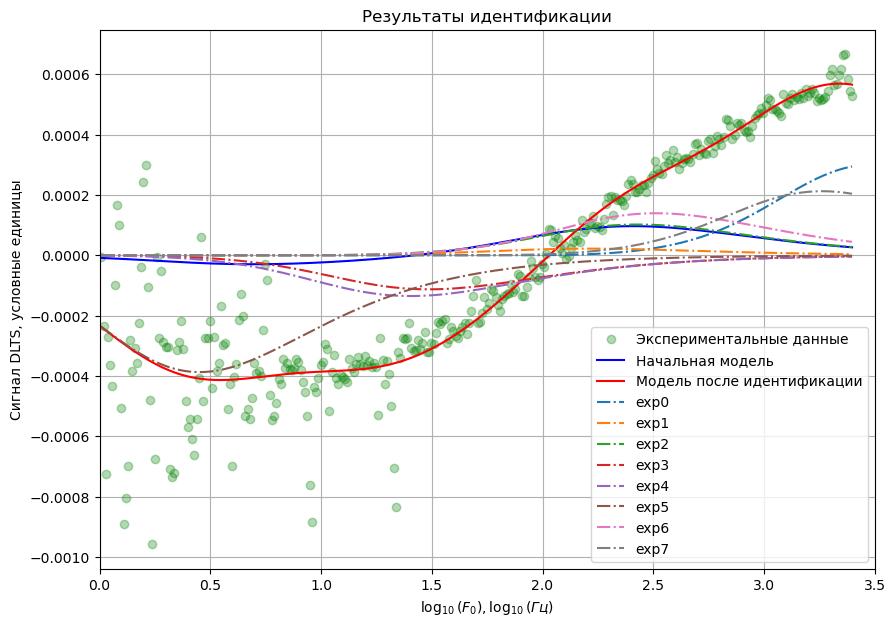

In [57]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

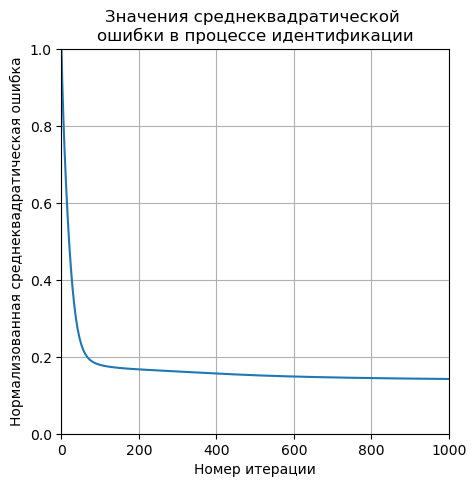

In [58]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [59]:
y_pred = multiexp_fs.predict(X_train)

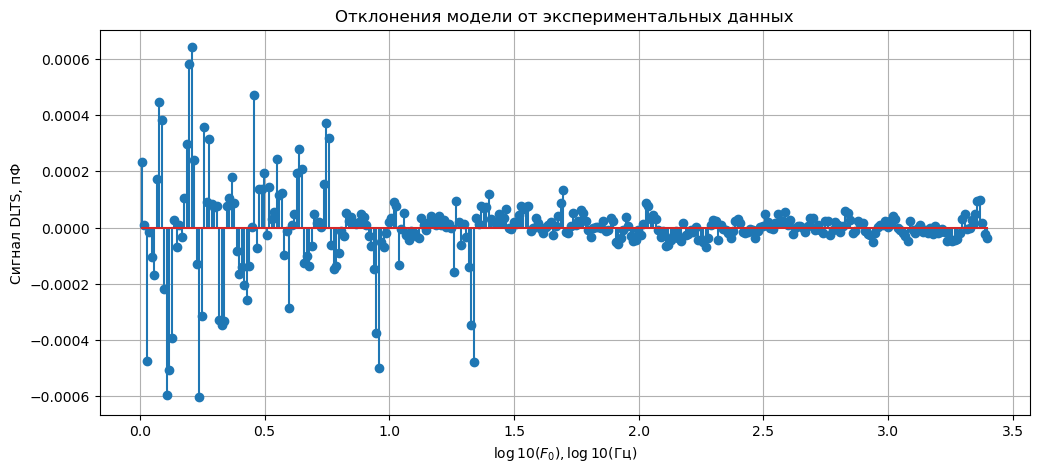

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

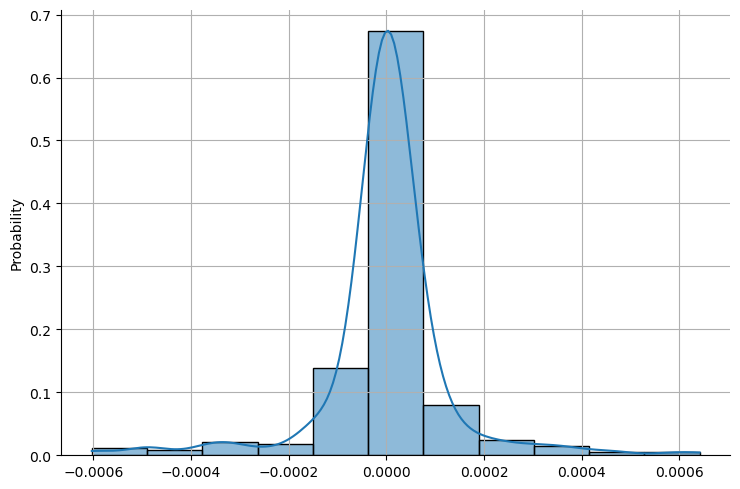

In [61]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [62]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 17:09:08.716627: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:09:08.716649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:09:08.716653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:09:08.716753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:09:08.716766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:09:08.716769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:09:08.716872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.0001866  0.00010139 0.00012492 0.00013535 0.00012137]
Mean: 0.00013392605275405653
Standard deviation: 2.8543159185881217e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [63]:
mean_squared_error(y_train, y_pred, squared=False)

0.00013194948977932327

Выведем на экран полученный спектр

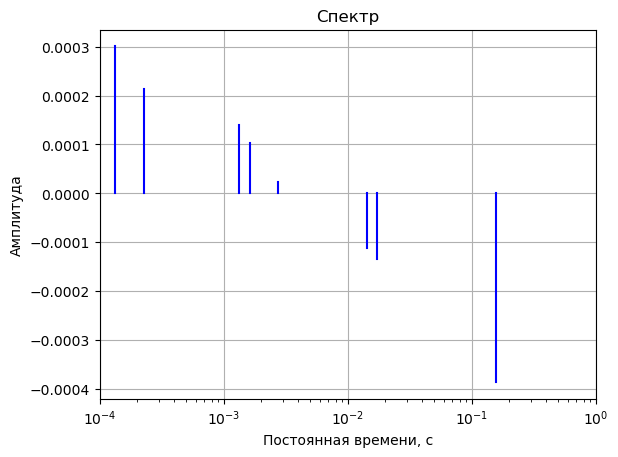

In [64]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

Чтение данных

In [65]:
print(data_frames[1][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


In [66]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])

Выведем тренировачный набор данных

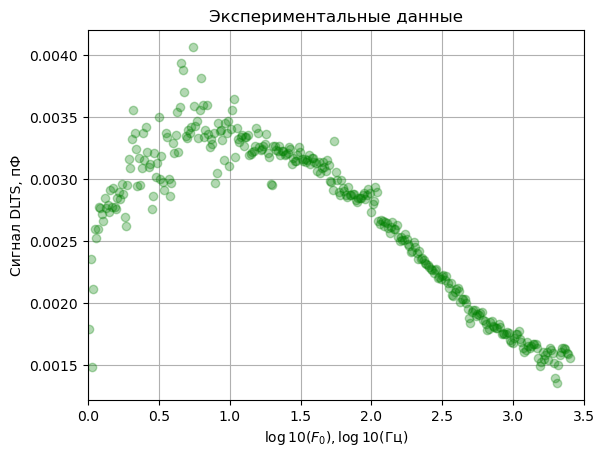

In [67]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

Идентификация модели:

In [68]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [69]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [70]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
139,0.003440,0.00001,True,0.05,2.605757e-08,1,1000,0.172201,0.00001,-1.265815,False
140,0.003441,0.00001,True,0.05,2.603266e-08,1,1000,0.172335,0.00001,-1.265723,False
141,0.003442,0.00001,True,0.05,2.600944e-08,1,1000,0.172464,0.00001,-1.265641,False
142,0.003443,0.00001,True,0.05,2.598778e-08,1,1000,0.172590,0.00001,-1.265566,False
143,0.003444,0.00001,True,0.05,2.596758e-08,1,1000,0.172713,0.00001,-1.265500,False
144,0.003445,0.00001,True,0.05,2.594874e-08,1,1000,0.172831,0.00001,-1.265442,False
145,0.003446,0.00001,True,0.05,2.593115e-08,1,1000,0.172946,0.00001,-1.265391,False
146,0.003447,0.00001,True,0.05,2.591474e-08,1,1000,0.173058,0.00001,-1.265346,False
147,0.003448,0.00001,True,0.05,2.589942e-08,1,1000,0.173166,0.00001,-1.265307,False
148,0.003448,0.00001,True,0.05,2.588511e-08,1,1000,0.173271,0.00001,-1.265274,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

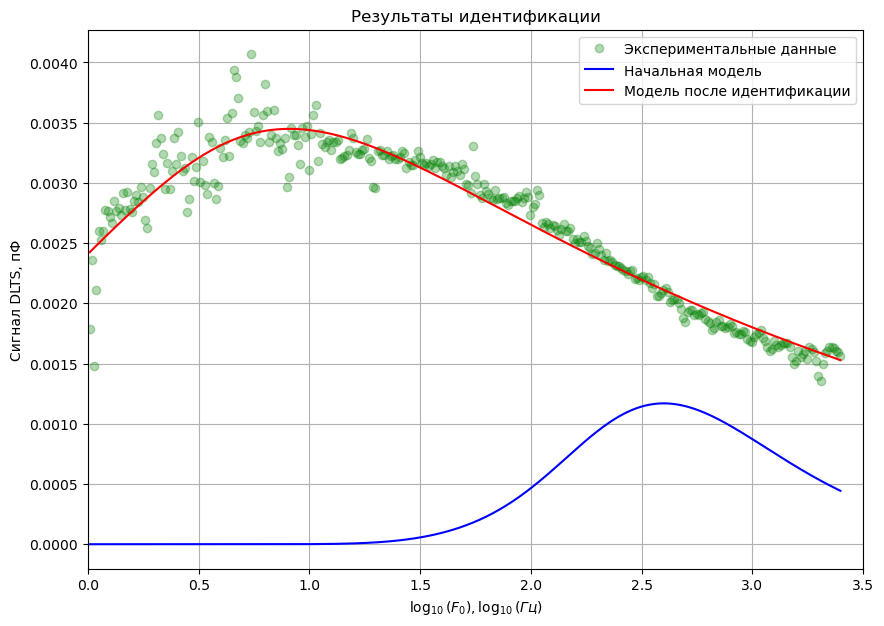

In [71]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

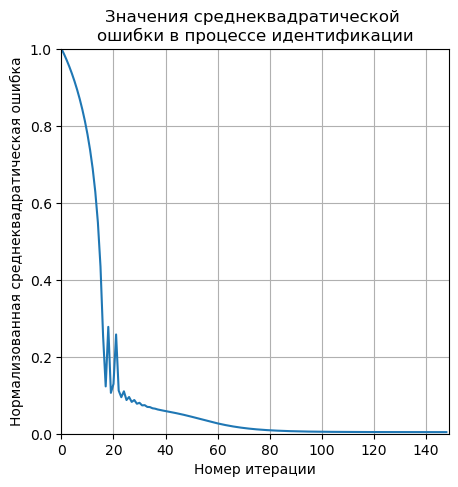

In [72]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

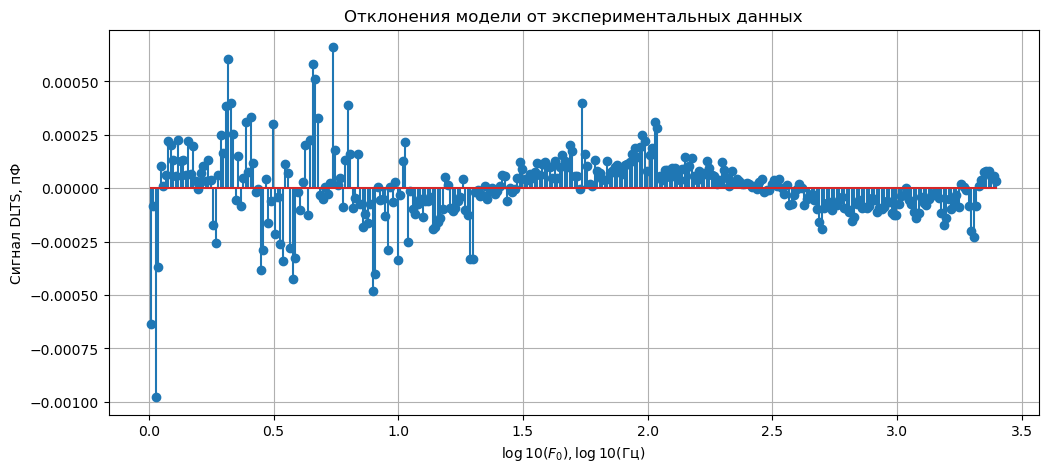

In [73]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

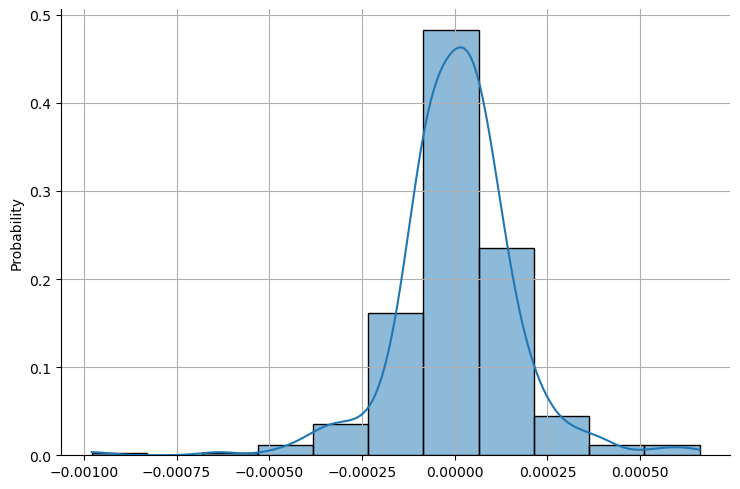

In [74]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [75]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00017818 0.00013745 0.00015627 0.0001586  0.00017158]
Mean: 0.00016041795339377906
Standard deviation: 1.4057627440898863e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [76]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00016088851434221306

Выведем на экран полученный спектр

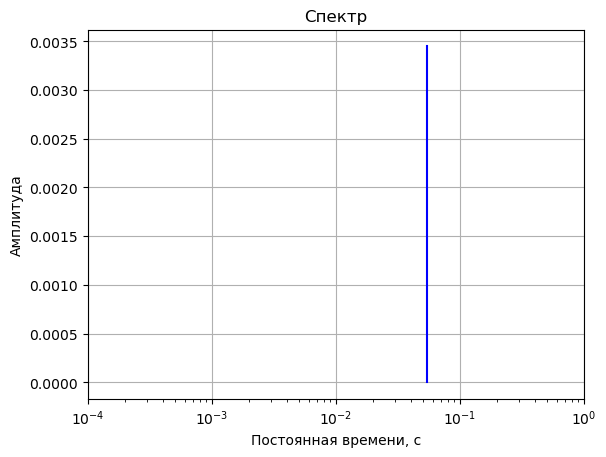

In [77]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [78]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [79]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [80]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
184,0.004582,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340020,False
185,0.004583,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340018,False
186,0.004584,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340017,False
187,0.004585,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340015,False
188,0.004586,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340014,False
189,0.004587,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340012,False
190,0.004588,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340011,False
191,0.004589,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340010,False
192,0.004590,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340008,False
193,0.004591,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.340007,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

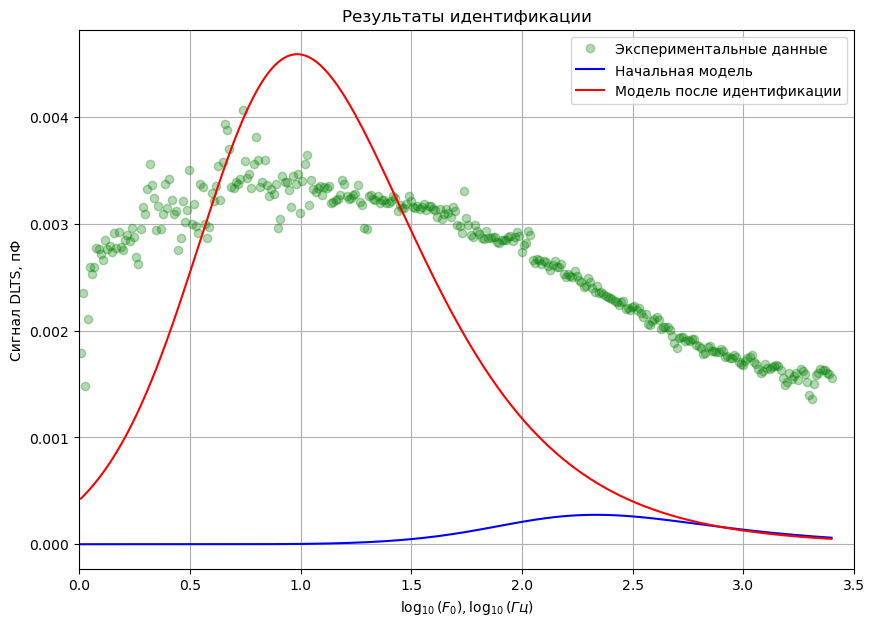

In [81]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

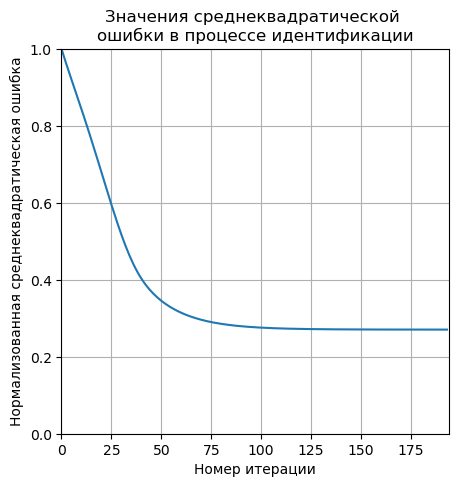

In [82]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

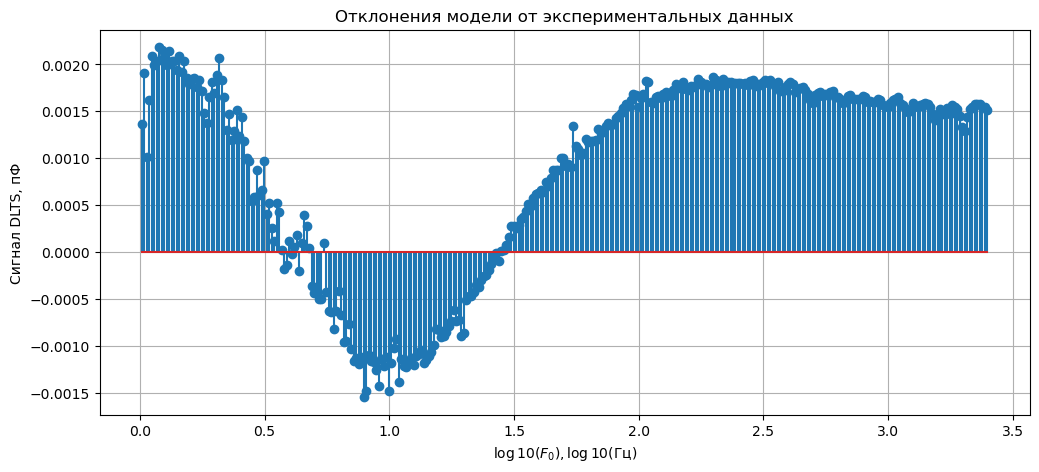

In [83]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

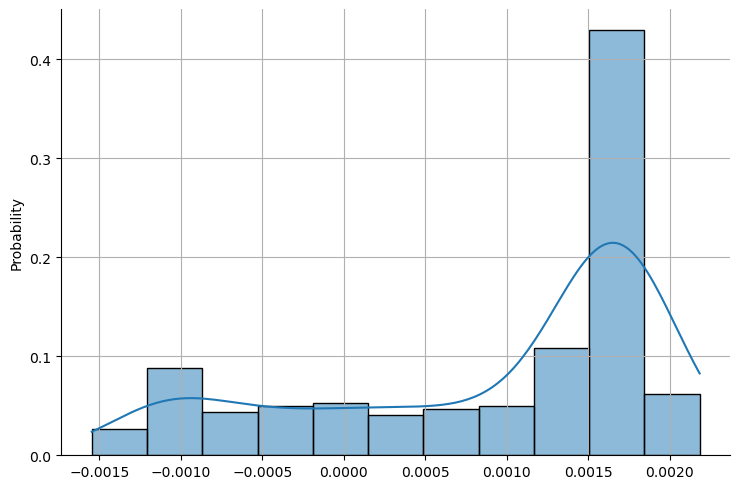

In [84]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [85]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 17:18:37.995372: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:18:37.995394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:18:37.995398: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:18:37.995507: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:18:37.995520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:18:37.995524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:18:37.995634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00148694 0.00138411 0.00135576 0.00137598 0.00137947]
Mean: 0.0013964516396641233
Standard deviation: 4.6267161457686985e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [86]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00138872033578103

Выведем на экран полученный спектр

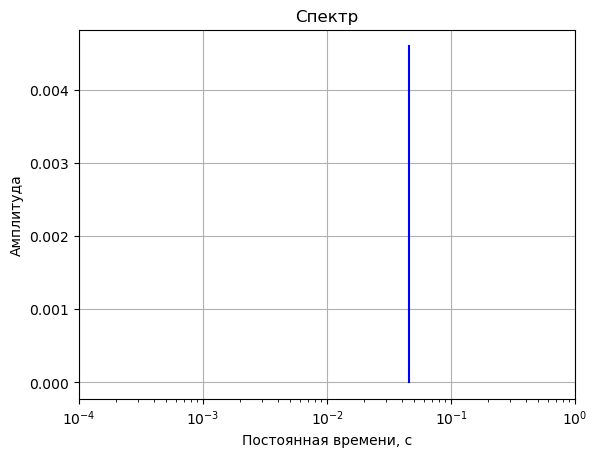

In [87]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [88]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [89]:
param_grid = {'n_exps': [5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [90]:
grid_search.fit(X_train, y_train)

2022-10-09 17:19:17.142752: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:19:17.142906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:19:17.142915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:19:17.143174: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:19:17.143228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:19:17.143261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:19:17.143482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [91]:
grid_search.best_params_

{'n_exps': 6}

Сохраним объект GridSearchCV

In [92]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.00015790771661833885 {'n_exps': 5}
0.00015301141489047345 {'n_exps': 6}
0.00015323281811918852 {'n_exps': 7}
0.0001547303746300327 {'n_exps': 8}
0.00015365434311633697 {'n_exps': 9}
0.00015466271596322817 {'n_exps': 10}


Сохраним лучшую модель

In [94]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [95]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
266,0.001510,0.000886,0.001107,0.001195,0.001710,0.001476,0.00001,0.05,2.436600e-08,6,1000,0.00001,-1.596167,-2.539447,-2.225848,-3.471430,-0.596134,-0.952395,False
267,0.001510,0.000886,0.001107,0.001195,0.001710,0.001476,0.00001,0.05,2.435059e-08,6,1000,0.00001,-1.596077,-2.539790,-2.225734,-3.471702,-0.595706,-0.952545,False
268,0.001511,0.000886,0.001107,0.001195,0.001710,0.001476,0.00001,0.05,2.433533e-08,6,1000,0.00001,-1.595987,-2.540132,-2.225621,-3.471973,-0.595280,-0.952695,False
269,0.001511,0.000886,0.001107,0.001195,0.001710,0.001476,0.00001,0.05,2.432023e-08,6,1000,0.00001,-1.595897,-2.540472,-2.225509,-3.472243,-0.594856,-0.952843,False
270,0.001511,0.000887,0.001108,0.001195,0.001710,0.001476,0.00001,0.05,2.430529e-08,6,1000,0.00001,-1.595808,-2.540811,-2.225399,-3.472512,-0.594435,-0.952990,False
271,0.001511,0.000887,0.001108,0.001195,0.001710,0.001476,0.00001,0.05,2.429049e-08,6,1000,0.00001,-1.595719,-2.541149,-2.225291,-3.472780,-0.594016,-0.953136,False
272,0.001512,0.000887,0.001108,0.001195,0.001710,0.001476,0.00001,0.05,2.427585e-08,6,1000,0.00001,-1.595631,-2.541485,-2.225184,-3.473047,-0.593599,-0.953281,False
273,0.001512,0.000887,0.001108,0.001196,0.001711,0.001476,0.00001,0.05,2.426135e-08,6,1000,0.00001,-1.595543,-2.541820,-2.225079,-3.473313,-0.593185,-0.953425,False
274,0.001512,0.000887,0.001108,0.001196,0.001711,0.001476,0.00001,0.05,2.424699e-08,6,1000,0.00001,-1.595455,-2.542153,-2.224976,-3.473578,-0.592773,-0.953568,False
275,0.001513,0.000887,0.001108,0.001196,0.001711,0.001476,0.00001,0.05,2.423277e-08,6,1000,0.00001,-1.595368,-2.542486,-2.224874,-3.473842,-0.592363,-0.953710,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

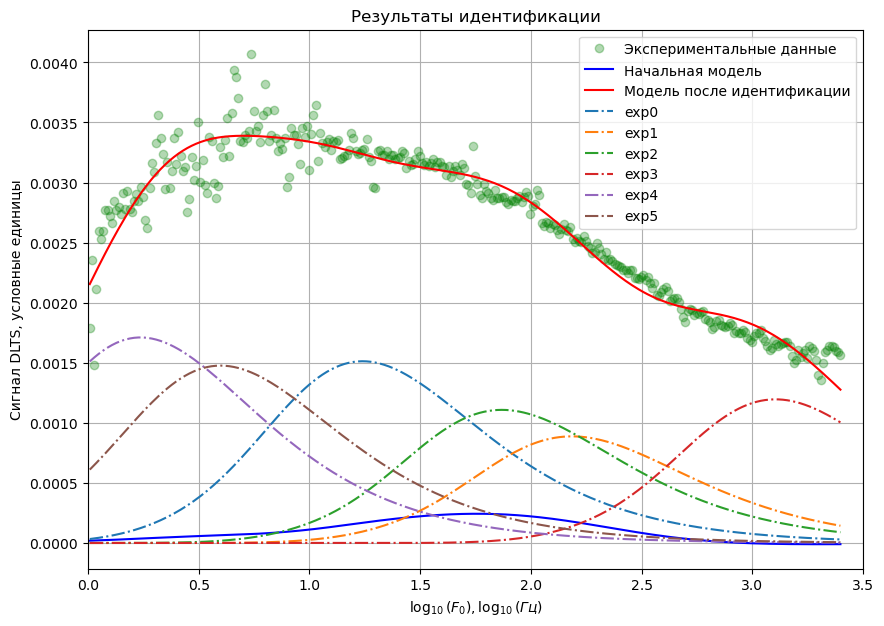

In [96]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

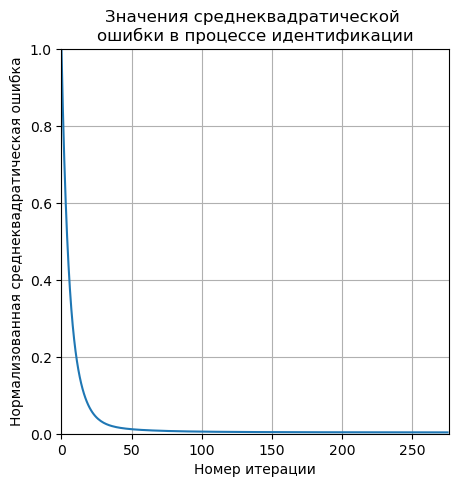

In [97]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [98]:
y_pred = multiexp_fs.predict(X_train)

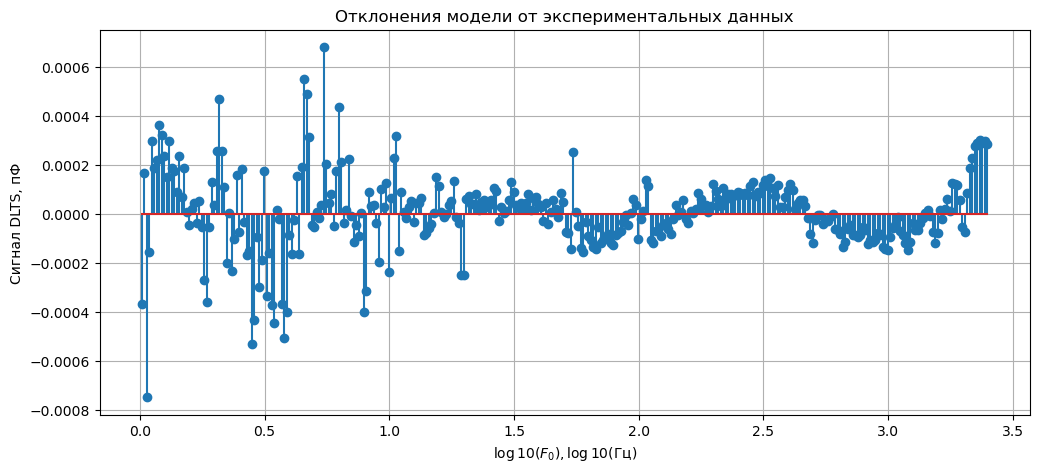

In [99]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

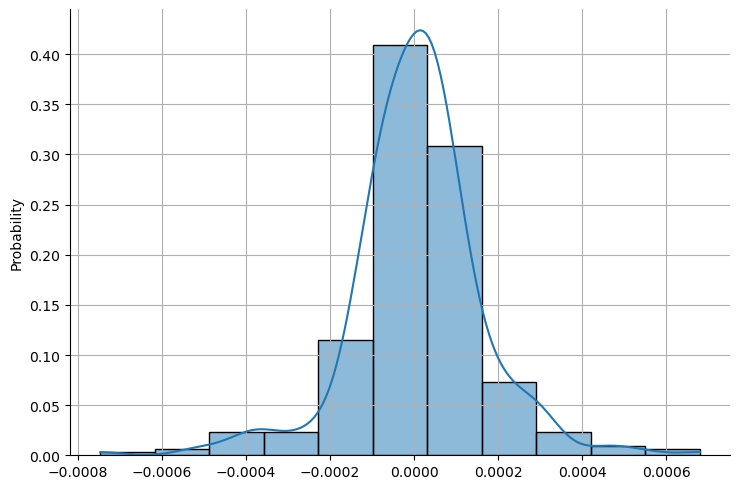

In [100]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [101]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 17:41:51.381129: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:41:51.381153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:41:51.381157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:41:51.381285: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:41:51.381299: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:41:51.381302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:41:51.381462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00017859 0.00012364 0.00015473 0.00017969 0.00015173]
Mean: 0.00015767536287170276
Standard deviation: 2.0611696074674127e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [102]:
mean_squared_error(y_train, y_pred, squared=False)

0.00015566876963798906

Выведем на экран полученный спектр

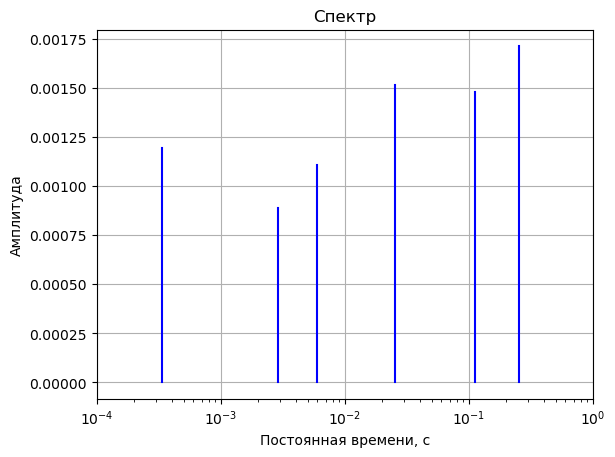

In [103]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 4.1. Подготовка экспериментальных данных

Чтение данных

In [104]:
print(data_frames[2][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


In [105]:
filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

Выведем тренировачный набор данных

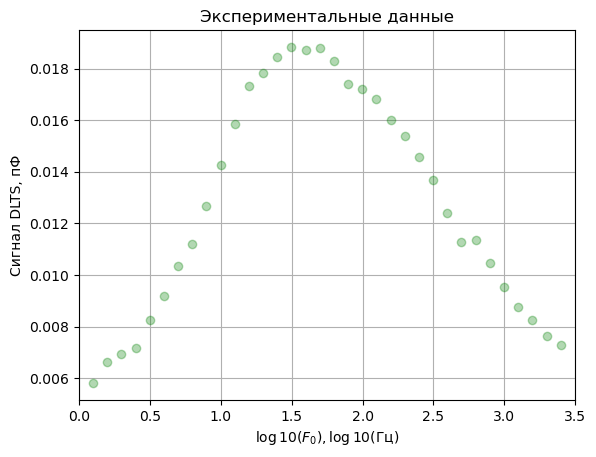

In [106]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_train_data.pdf',
            bbox_inches='tight')
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [107]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [108]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [109]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
157,0.018481,0.00001,True,0.05,4.390753e-07,1,1000,0.274539,0.00001,-1.920521,False
158,0.018486,0.00001,True,0.05,4.386126e-07,1,1000,0.274685,0.00001,-1.920494,False
159,0.018491,0.00001,True,0.05,4.381754e-07,1,1000,0.274826,0.00001,-1.920467,False
160,0.018495,0.00001,True,0.05,4.377622e-07,1,1000,0.274964,0.00001,-1.920442,False
161,0.018500,0.00001,True,0.05,4.373717e-07,1,1000,0.275097,0.00001,-1.920417,False
162,0.018504,0.00001,True,0.05,4.370027e-07,1,1000,0.275227,0.00001,-1.920393,False
163,0.018508,0.00001,True,0.05,4.366540e-07,1,1000,0.275354,0.00001,-1.920370,False
164,0.018512,0.00001,True,0.05,4.363244e-07,1,1000,0.275476,0.00001,-1.920347,False
165,0.018516,0.00001,True,0.05,4.360130e-07,1,1000,0.275596,0.00001,-1.920325,False
166,0.018520,0.00001,True,0.05,4.357186e-07,1,1000,0.275712,0.00001,-1.920304,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

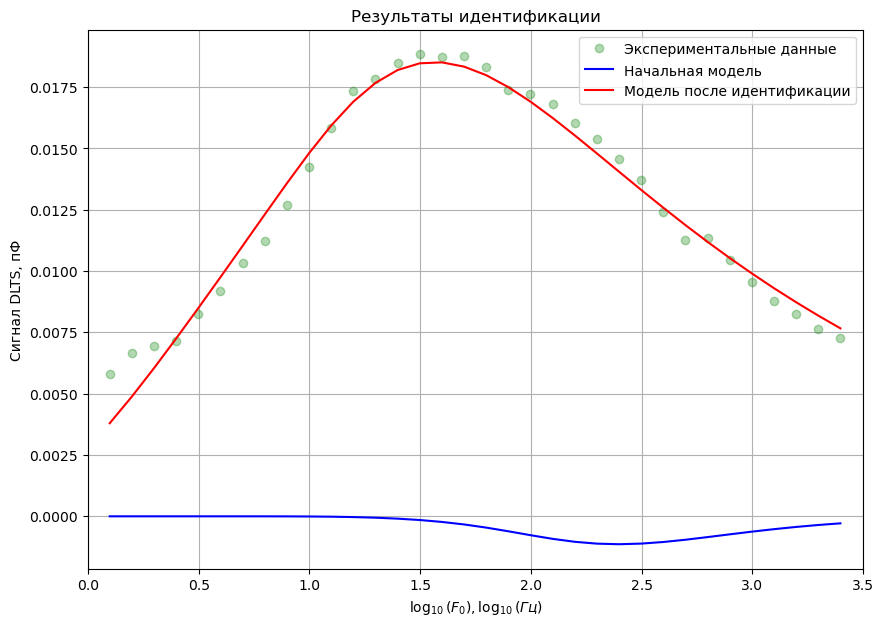

In [110]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

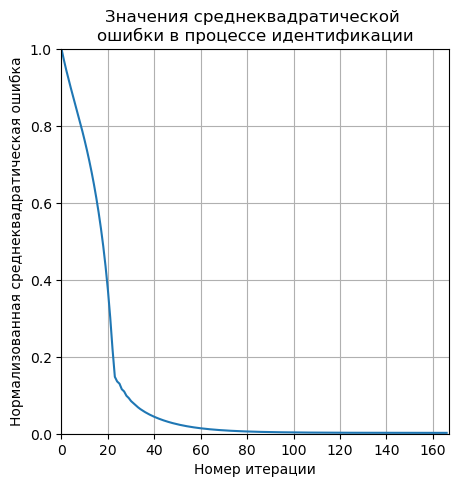

In [111]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

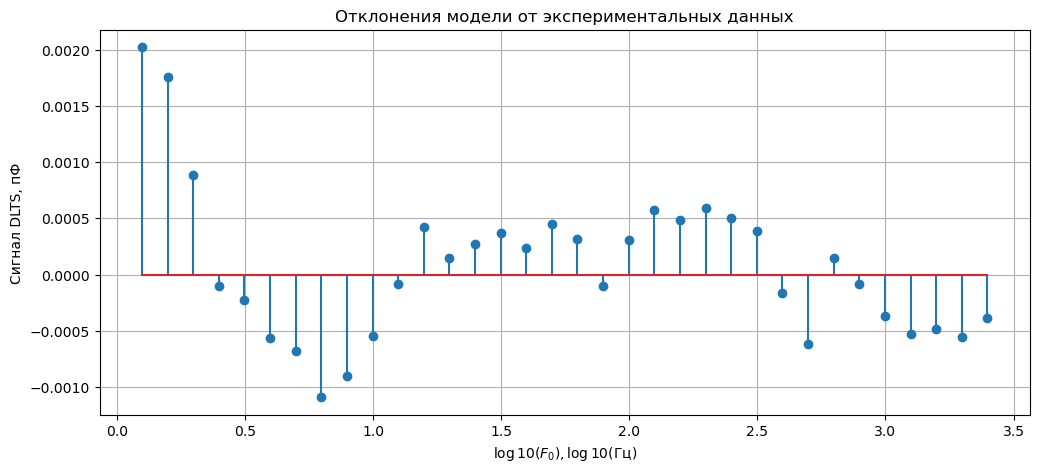

In [112]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

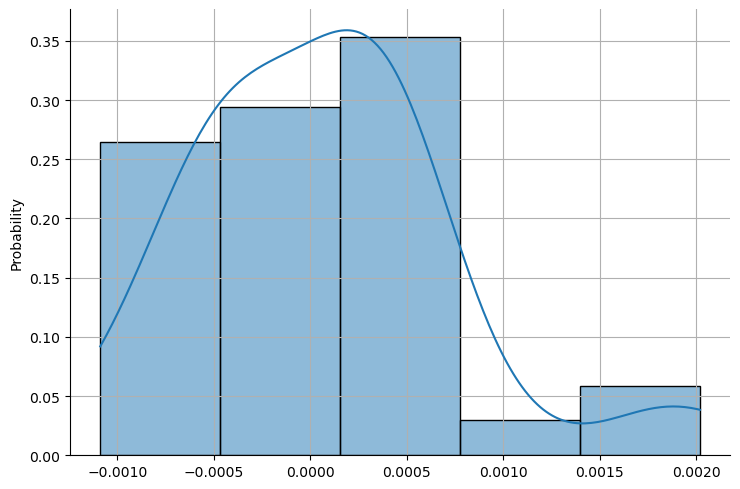

In [113]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [114]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 17:53:52.404724: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:53:52.404748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:53:52.404752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:53:52.404924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:53:52.404938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:53:52.404942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:53:52.405107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.0007131  0.00080731 0.00055247 0.00052742 0.00096495]
Mean: 0.0007130490560020009
Standard deviation: 0.0001628409519994299


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [115]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0006600898585815408

Выведем на экран полученный спектр

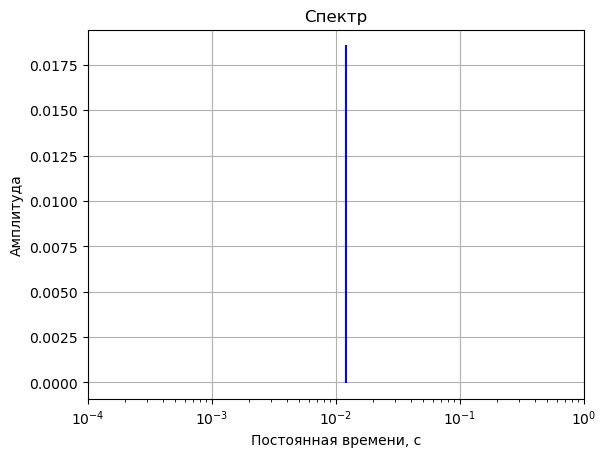

In [116]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [117]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [118]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [119]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
190,0.023798,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931466,False
191,0.023803,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931467,False
192,0.023808,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931468,False
193,0.023812,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931469,False
194,0.023817,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931469,False
195,0.023821,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931470,False
196,0.023825,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931471,False
197,0.023829,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931472,False
198,0.023833,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931473,False
199,0.023837,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931474,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

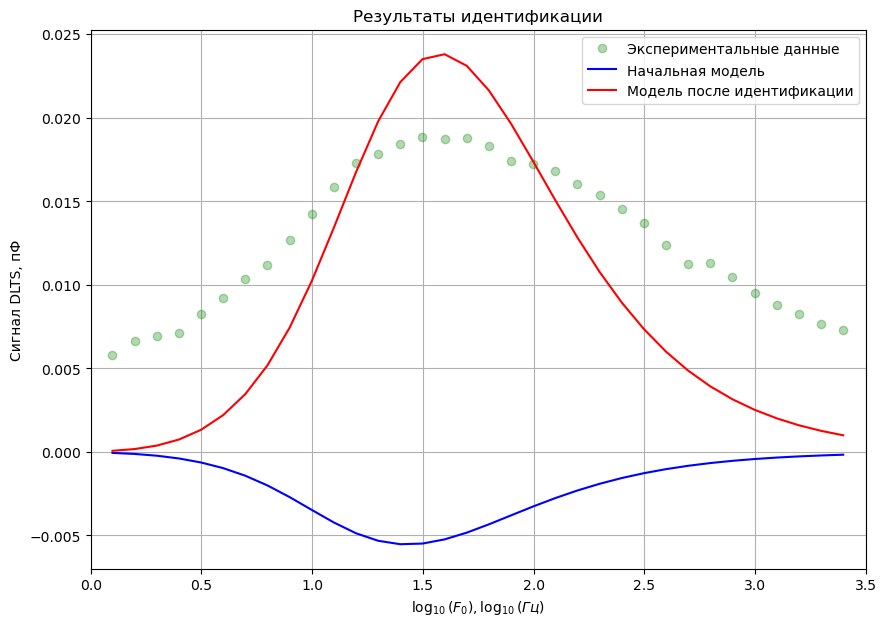

In [120]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

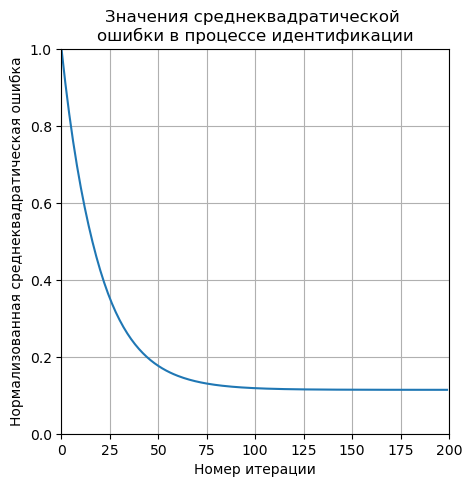

In [121]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

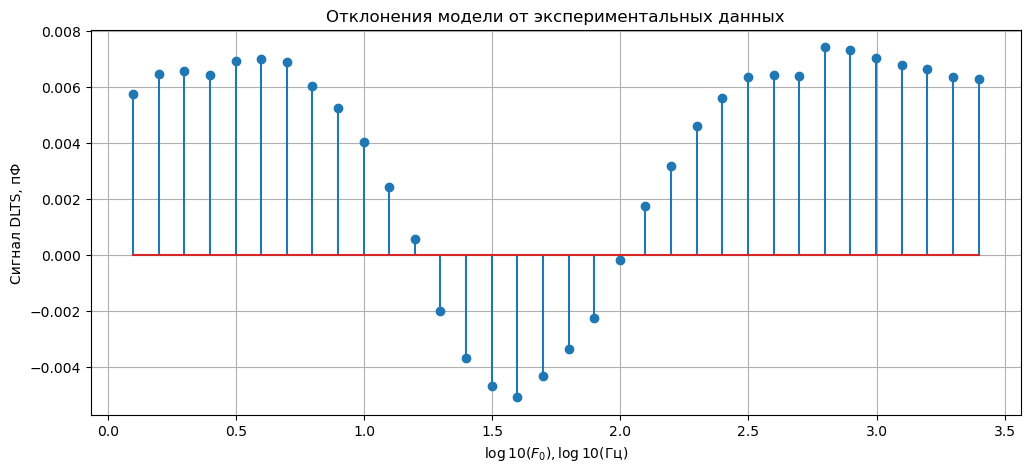

In [122]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

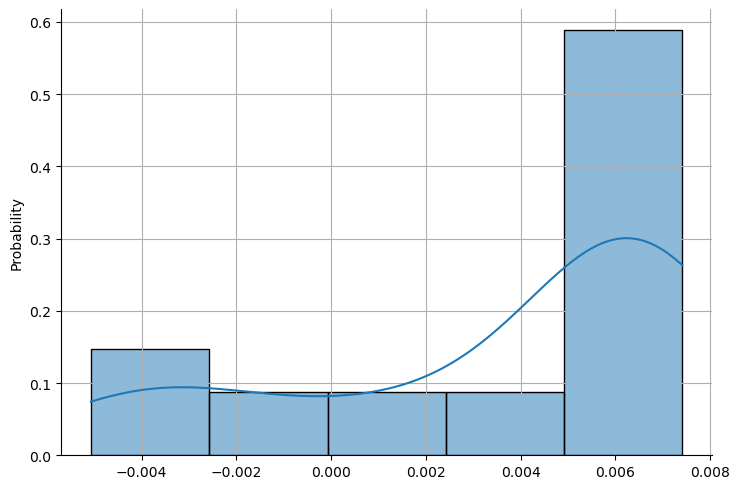

In [123]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [124]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 17:54:44.776730: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:54:44.776730: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:54:44.776752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:54:44.776752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:54:44.776756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:54:44.776757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:54:44.776859: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:54:44.776860: I

Scores - корни из среднеквадратических ошибок
Scores: [0.00550633 0.00555719 0.00642194 0.00622863 0.00547302]
Mean: 0.0058374227059669655
Standard deviation: 0.00040389246320326344


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [125]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0054364806025625784

Выведем на экран полученный спектр

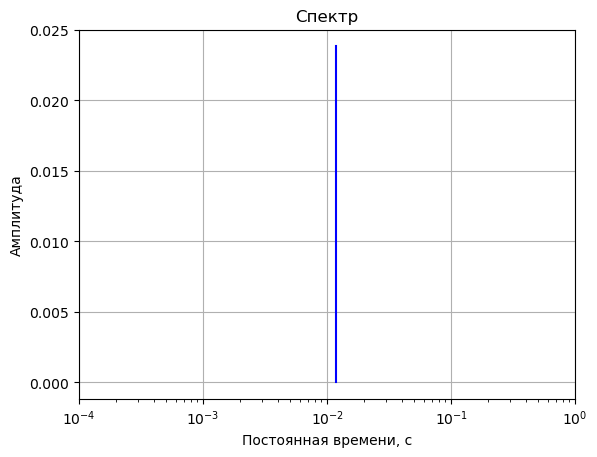

In [126]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [127]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [128]:
param_grid = {'n_exps': [5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [129]:
grid_search.fit(X_train, y_train)

2022-10-09 17:55:14.697011: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 17:55:14.697040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 17:55:14.697044: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 17:55:14.697275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 17:55:14.697294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 17:55:14.697298: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 17:55:14.697500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [130]:
grid_search.best_params_

{'n_exps': 6}

Сохраним объект GridSearchCV

In [131]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [132]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.0005613505158034344 {'n_exps': 5}
0.00039768033035024865 {'n_exps': 6}
0.0004187327471718309 {'n_exps': 7}
0.0004463596803313574 {'n_exps': 8}
0.0004571550560746107 {'n_exps': 9}
0.00044758413397155537 {'n_exps': 10}


Сохраним лучшую модель

In [133]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [134]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
281,0.004915,0.005913,0.006576,0.005552,0.006496,0.006720,0.00001,0.05,1.168956e-07,6,1000,0.00001,-3.514957,-2.733989,-1.658264,-2.239109,-1.801839,-0.803884,False
282,0.004915,0.005914,0.006577,0.005552,0.006497,0.006719,0.00001,0.05,1.165762e-07,6,1000,0.00001,-3.515188,-2.733998,-1.658323,-2.239247,-1.801496,-0.803558,False
283,0.004915,0.005915,0.006578,0.005553,0.006498,0.006717,0.00001,0.05,1.162584e-07,6,1000,0.00001,-3.515419,-2.734007,-1.658381,-2.239386,-1.801154,-0.803232,False
284,0.004914,0.005917,0.006579,0.005553,0.006498,0.006715,0.00001,0.05,1.159424e-07,6,1000,0.00001,-3.515649,-2.734016,-1.658439,-2.239525,-1.800814,-0.802909,False
285,0.004914,0.005918,0.006580,0.005554,0.006499,0.006714,0.00001,0.05,1.156280e-07,6,1000,0.00001,-3.515878,-2.734024,-1.658496,-2.239663,-1.800474,-0.802586,False
286,0.004914,0.005919,0.006581,0.005554,0.006500,0.006712,0.00001,0.05,1.153152e-07,6,1000,0.00001,-3.516106,-2.734033,-1.658552,-2.239802,-1.800136,-0.802265,False
287,0.004913,0.005920,0.006582,0.005555,0.006501,0.006710,0.00001,0.05,1.150041e-07,6,1000,0.00001,-3.516335,-2.734041,-1.658608,-2.239941,-1.799799,-0.801946,False
288,0.004913,0.005922,0.006584,0.005555,0.006502,0.006709,0.00001,0.05,1.146946e-07,6,1000,0.00001,-3.516562,-2.734049,-1.658663,-2.240080,-1.799464,-0.801628,False
289,0.004912,0.005923,0.006585,0.005556,0.006503,0.006707,0.00001,0.05,1.143867e-07,6,1000,0.00001,-3.516789,-2.734057,-1.658717,-2.240218,-1.799130,-0.801311,False
290,0.004912,0.005924,0.006586,0.005556,0.006504,0.006706,0.00001,0.05,1.140804e-07,6,1000,0.00001,-3.517015,-2.734065,-1.658771,-2.240357,-1.798797,-0.800995,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

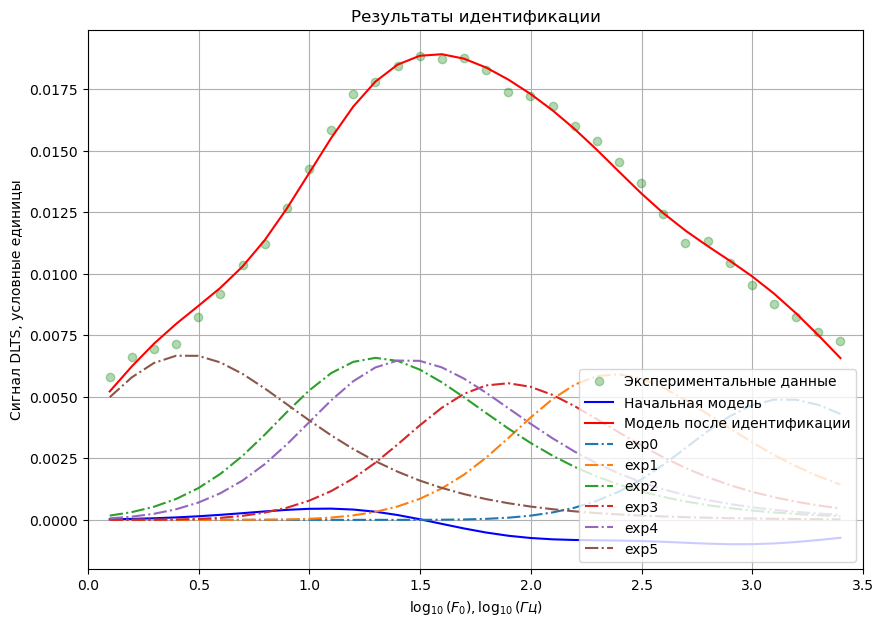

In [135]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.legend(loc='lower right')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

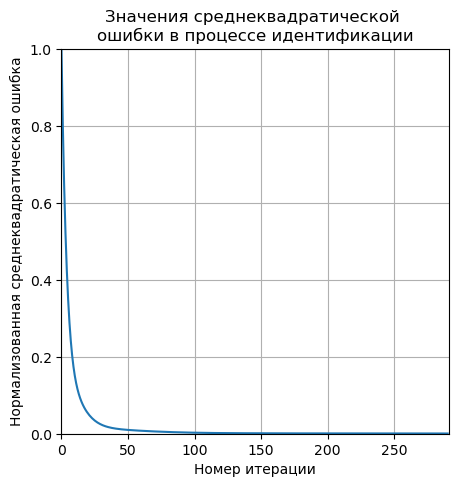

In [136]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [137]:
y_pred = multiexp_fs.predict(X_train)

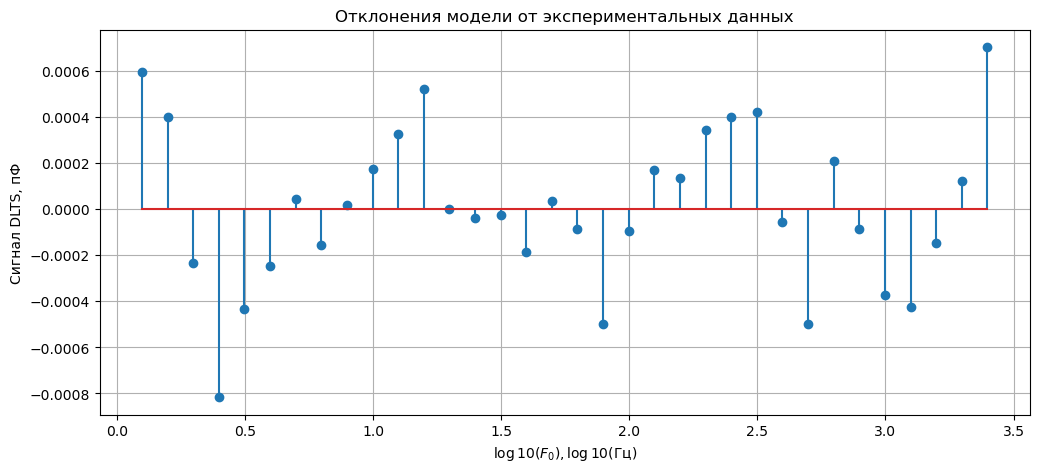

In [138]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

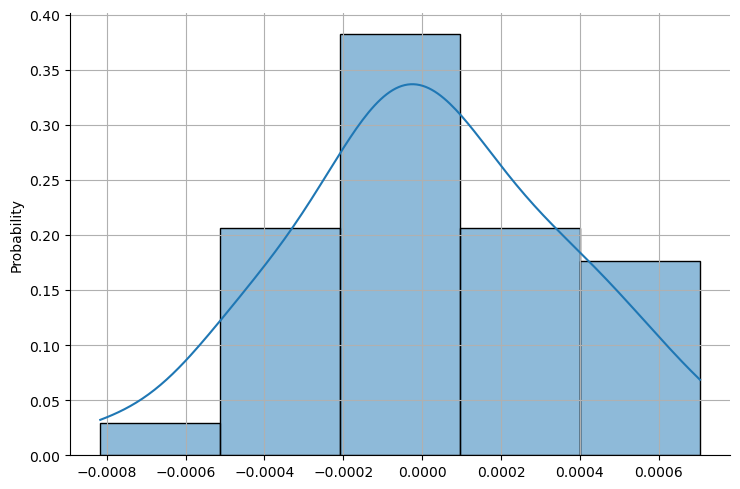

In [139]:
sns.displot(x=y_train - y_pred, bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [140]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-09 18:21:46.856617: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-09 18:21:46.856638: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-09 18:21:46.856647: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-09 18:21:46.856779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-09 18:21:46.856792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-09 18:21:46.856796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-09 18:21:46.856921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00031752 0.00055294 0.00034993 0.00030534 0.00068605]
Mean: 0.00044235590237926855
Standard deviation: 0.00015133574994105454


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [141]:
mean_squared_error(y_train, y_pred, squared=False)

0.00033775791607220133

Выведем на экран полученный спектр

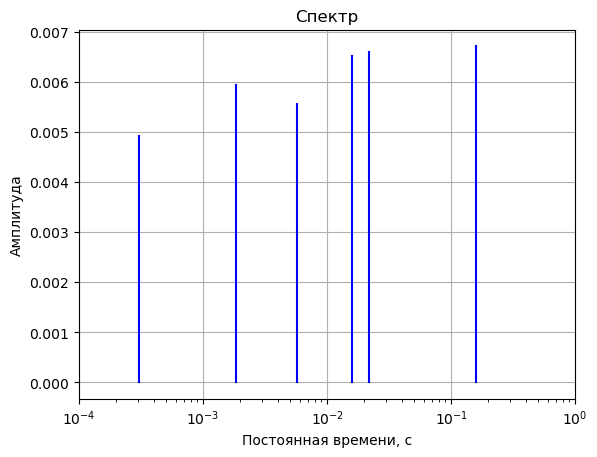

In [142]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()